# Adatforrás

## Linkek

https://www.semanticscholar.org/reader/e81657338e48b233c8c6019832e6670fa552adb4

https://archive.ics.uci.edu/dataset/372/htru2

## Adatok jellege

Az HTRU2 adatbázis a High Time Resolution Universe Survey során gyűjtött pulzárjelölt adatokat tartalmazza. A pulzárok gyorsan forgó neutroncsillagok, melyek rádiójelet bocsátanak ki, ezek periodikusan ismétlődnek, és földi teleszkópokkal észlelhetők. A jelöltek többsége azonban nem valódi pulzár, hanem zaj vagy rádiófrekvenciás interferencia következménye, így nehéz azonosítani a valódi pulzárokat. Az adatbázis 16259 hamis és 1639 valódi pulzár példát tartalmaz, amelyeket emberi annotátorok ellenőriztek.

# Python

## Importok

In [1]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
import pandas as pd
from sklearn.decomposition import PCA
from factor_analyzer import Rotator
from sklearn.manifold import MDS, Isomap
from factor_analyzer import FactorAnalyzer
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import gridspec

## Saját függvények

A megjelenítéssel foglalkozó eljárások.

In [2]:
def grafikon_scatter_2d(data):

    fig, axes = plt.subplots(1, len(data["figs"]), figsize=(len(data["figs"]) * 8, 8))
    targets = [0, 1]
    colors = ['r', 'g']

    for d in data["figs"]:
        axes[d["id"]].set_title(f'HTRU2 - 2D - {d["method"]} ({d["msg"]})', fontsize=16)
        axes[d["id"]].set_xlabel(data["x_label"])
        axes[d["id"]].set_ylabel(data["y_label"])
        for target, color in zip(targets, colors):
            indicesToKeep = data["data"]['class'] == target
            axes[d["id"]].scatter(data["data"].loc[indicesToKeep, d["x"]],
                            data["data"].loc[indicesToKeep, d["y"]],
                            c=color, s=1)
        axes[d["id"]].legend(targets)

    plt.tight_layout()
    plt.show()

In [3]:
def grafikon_scatter_3d(data):
    num_figs = len(data["figs"])
    fig = plt.figure(figsize=(num_figs * 8, 8))
    axes = []

    for i in range(num_figs):
        ax = fig.add_subplot(1, num_figs, i + 1, projection='3d')
        axes.append(ax)

    targets = [0, 1]
    colors = ['r', 'g']

    for d in data["figs"]:
        ax = axes[d["id"]]
        ax.set_title(f'HTRU2 - 3D - {d["method"]} ({d["msg"]})', fontsize=16)
        ax.set_xlabel(data["x_label"])
        ax.set_ylabel(data["y_label"])
        ax.set_zlabel(data["z_label"])
        for target, color in zip(targets, colors):
            indicesToKeep = data["data"]['class'] == target
            ax.scatter(
                data["data"].loc[indicesToKeep, d["x"]], 
                data["data"].loc[indicesToKeep, d["y"]], 
                data["data"].loc[indicesToKeep, d["z"]], 
                c=color, 
                s=1, 
                label=f'{target}')
        ax.legend()

    plt.show()


In [4]:
def grafikon_scatter_forgathato_3d(data):
    num_figs = len(data["figs"])
    fig = make_subplots(rows=1, cols=num_figs, specs=[[{'type': 'scatter3d'}]*num_figs],
                        subplot_titles=[f'{d["method"]} ({d["msg"]})' for d in data["figs"]])
    
    targets = [0, 1]
    colors = ['red', 'green']

    for i, d in enumerate(data["figs"]):
        for target, color in zip(targets, colors):
            indicesToKeep = data["data"]['class'] == target
            fig.add_trace(
                go.Scatter3d(
                    x=data["data"].loc[indicesToKeep, d["x"]],
                    y=data["data"].loc[indicesToKeep, d["y"]],
                    z=data["data"].loc[indicesToKeep, d["z"]],
                    mode='markers',
                    marker=dict(size=1, color=color),
                    name=f'{target}',
                    legendgroup=f'{target}',
                    showlegend=(i == 0)
                ),
                row=1, col=i+1
            )
    
    fig.update_layout(
        height=600,
        width=600 * num_figs,
        title_text="HTRU2 - 3D Scatter Plots",
        scene=dict(
            xaxis_title=data["x_label"],
            yaxis_title=data["y_label"],
            zaxis_title=data["z_label"]
        )
    )

    fig.show()

In [5]:
def grafikon_rendezett(X, feature_cimkek):
    num_cols = 4
    num_rows = 2
    plots_per_fig = num_cols * num_rows

    for i, adat in enumerate(feature_cimkek):
        if i % plots_per_fig == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
            plt.style.use('ggplot')
            fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
            axs = axs.flatten()

        ax = axs[i % plots_per_fig]
        sorted_data = np.sort(X[adat].unique())
        sorted_data_999 = np.percentile(sorted_data, 99.0)
        sorted_data_01 = np.percentile(sorted_data, 1.0)

        ax.plot(range(len(sorted_data)), sorted_data, marker='o', linestyle='-', color='steelblue', alpha=0.7, markersize=3)
        ax.set_title(adat, fontsize=12)
        ax.set_xlabel('sorszám', fontsize=10)
        ax.set_ylabel('érték', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.axhline(y=X[adat].mean(), color='red', linestyle='--', label=f'Átlag: {X[adat].mean():.2f} mp')
        ax.axhline(y=X[adat].median(), color='green', linestyle='--', label=f'Medián: {X[adat].median():.2f} mp')
        ax.axhline(y=sorted_data_999, color='magenta', linestyle='--', label=f'99.9%: {sorted_data_999:.2f}')
        ax.axhline(y=sorted_data_01, color='blue', linestyle='--', label=f'0.1%: {sorted_data_01:.2f}')
        ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

In [6]:
def grafikon_eloszlas(X, feature_list):
    sns.set_style("whitegrid")
    sns.set_palette("muted")

    num_cols = 4
    num_rows = 2
    plots_per_fig = num_cols * num_rows

    for i, adat in enumerate(feature_list):
        if i % plots_per_fig == 0:
            if i > 0:
                plt.tight_layout()
                plt.show()
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
            axes = axes.flatten()

        ax = axes[i % plots_per_fig]
        sns.histplot(data=X, x=adat, kde=True, color='steelblue', ax=ax)
        ax.set_title(f"{adat} eloszlás", fontsize=12)
        ax.set_xlabel(adat)
        ax.set_ylabel("Gyakoriság")
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Adatok

## Betöltés

In [7]:
htru2 = fetch_ucirepo(id=372)

In [8]:
X = htru2.data.features
y = htru2.data.targets

## Adatok vizsgálata

In [9]:
len(X), len(y)

(17898, 17898)

In [10]:
hianyzo_ertekek = X.isnull().sum()
hianyzo_ertekek

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
dtype: int64

In [11]:
X.describe()

Profile_mean  Profile_stdev  Profile_skewness  Profile_kurtosis  \
count  17898.000000   17898.000000      17898.000000      17898.000000   
mean     111.079968      46.549532          0.477857          1.770279   
std       25.652935       6.843189          1.064040          6.167913   
min        5.812500      24.772042         -1.876011         -1.791886   
25%      100.929688      42.376018          0.027098         -0.188572   
50%      115.078125      46.947479          0.223240          0.198710   
75%      127.085938      51.023202          0.473325          0.927783   
max      192.617188      98.778911          8.069522         68.101622   

            DM_mean      DM_stdev   DM_skewness   DM_kurtosis  
count  17898.000000  17898.000000  17898.000000  17898.000000  
mean      12.614400     26.326515      8.303556    104.857709  
std       29.472897     19.470572      4.506092    106.514540  
min        0.213211      7.370432     -3.139270     -1.976976  
25%        1.923077     14.437332      5.781506     34.960504  
50%        2.801839     18.461316      8.433515     83.064556  
75%        5.464256     28.428104     10.702959    139.309330  
max      223.392141    110.642211     34.539844   1191.000837

In [12]:
feature_cimkek = list(X.columns)
print(feature_cimkek)

['Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis', 'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis']


Profile_mean – A kvazár rádiófrekvenciás profiljának átlagos intenzitása, azaz az adott hullámforma középértéke.

Profile_stdev – A profil intenzitásának szórása, ami azt mutatja, mennyire ingadozik az érték az átlag körül.

Profile_skewness – A profil aszimmetriáját jelzi.

Profile_kurtosis – A profil csúcsosságát vagy laposságát mutatja az eloszlás normálishoz viszonyított alakja alapján.

DM_mean – A diszperziós mérték (Dispersion Measure) átlagos értéke, amely megmutatja, mennyi anyagon haladt át a jel.

DM_stdev – A diszperziós mérték szórása, azaz mennyire változó ez az érték a mérések során.

DM_skewness – A diszperziós mérték eloszlásának aszimmetriáját mutatja, hasonlóan a profilhoz.

DM_kurtosis – A diszperziós mérték eloszlásának csúcsosságát vagy laposságát jellemzi.

In [13]:
X.head()

Profile_mean  Profile_stdev  Profile_skewness  Profile_kurtosis   DM_mean  \
0    140.562500      55.683782         -0.234571         -0.699648  3.199833   
1    102.507812      58.882430          0.465318         -0.515088  1.677258   
2    103.015625      39.341649          0.323328          1.051164  3.121237   
3    136.750000      57.178449         -0.068415         -0.636238  3.642977   
4     88.726562      40.672225          0.600866          1.123492  1.178930   

    DM_stdev  DM_skewness  DM_kurtosis  
0  19.110426     7.975532    74.242225  
1  14.860146    10.576487   127.393580  
2  21.744669     7.735822    63.171909  
3  20.959280     6.896499    53.593661  
4  11.468720    14.269573   252.567306

A sorbarendezett egyedi adatokat rajzoltatom itt ki, hogy lássam milyen skálán helyezkednek el.

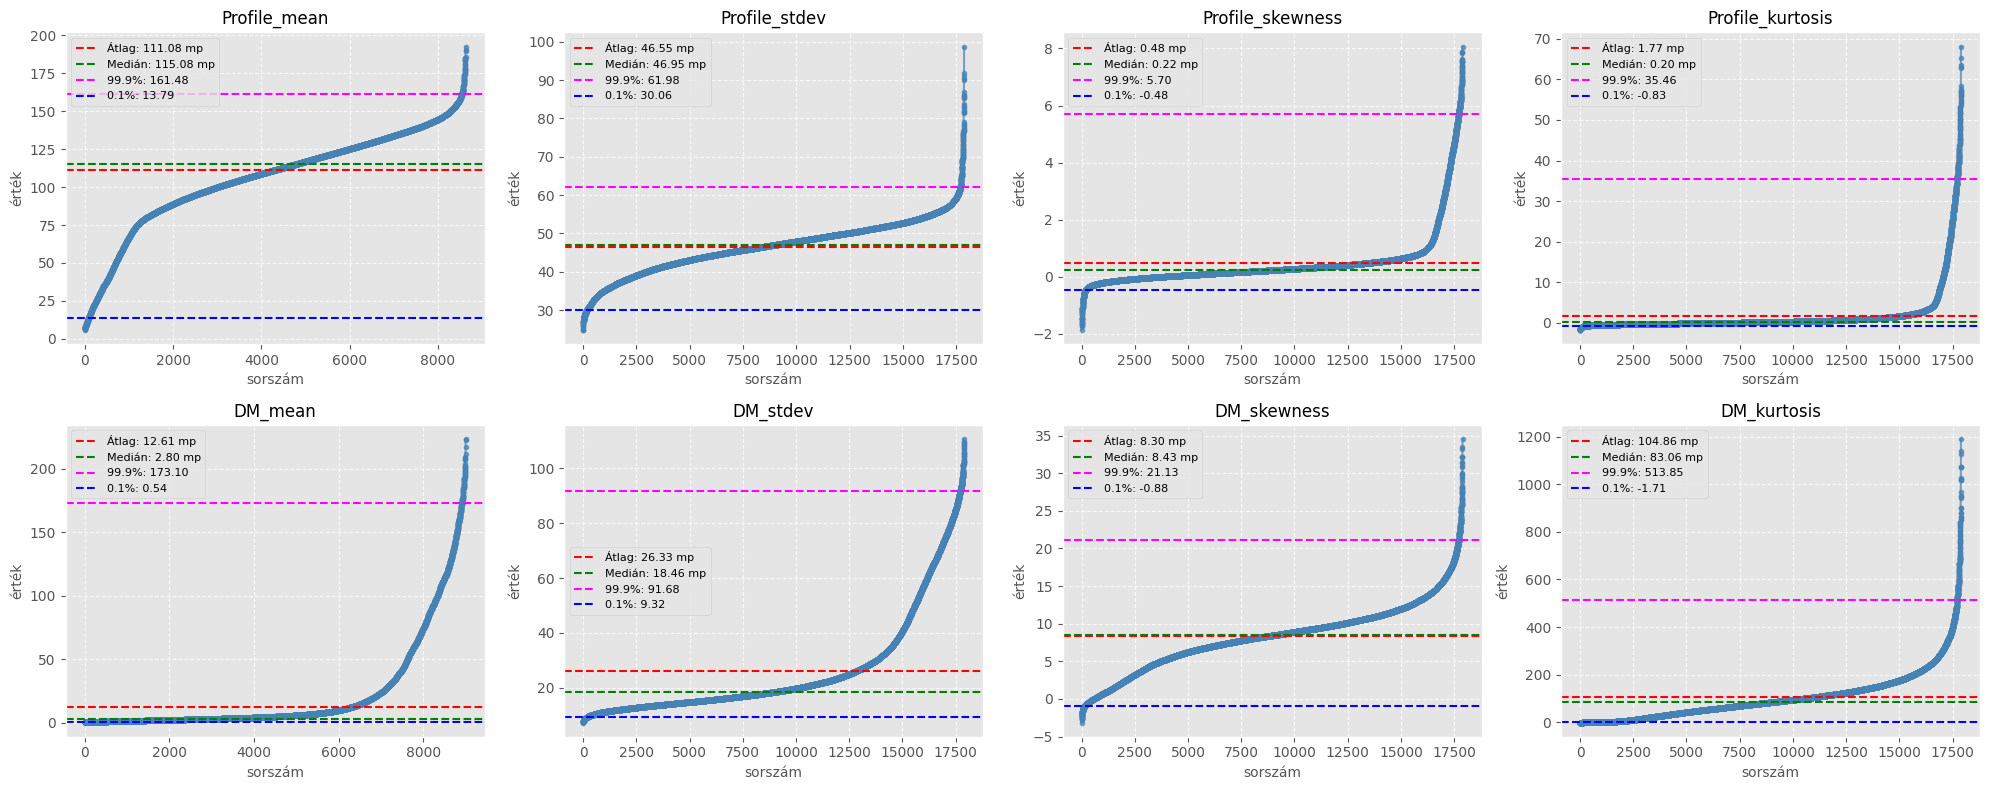

In [14]:
grafikon_rendezett(X, feature_cimkek)


Az adatok eloszlása.

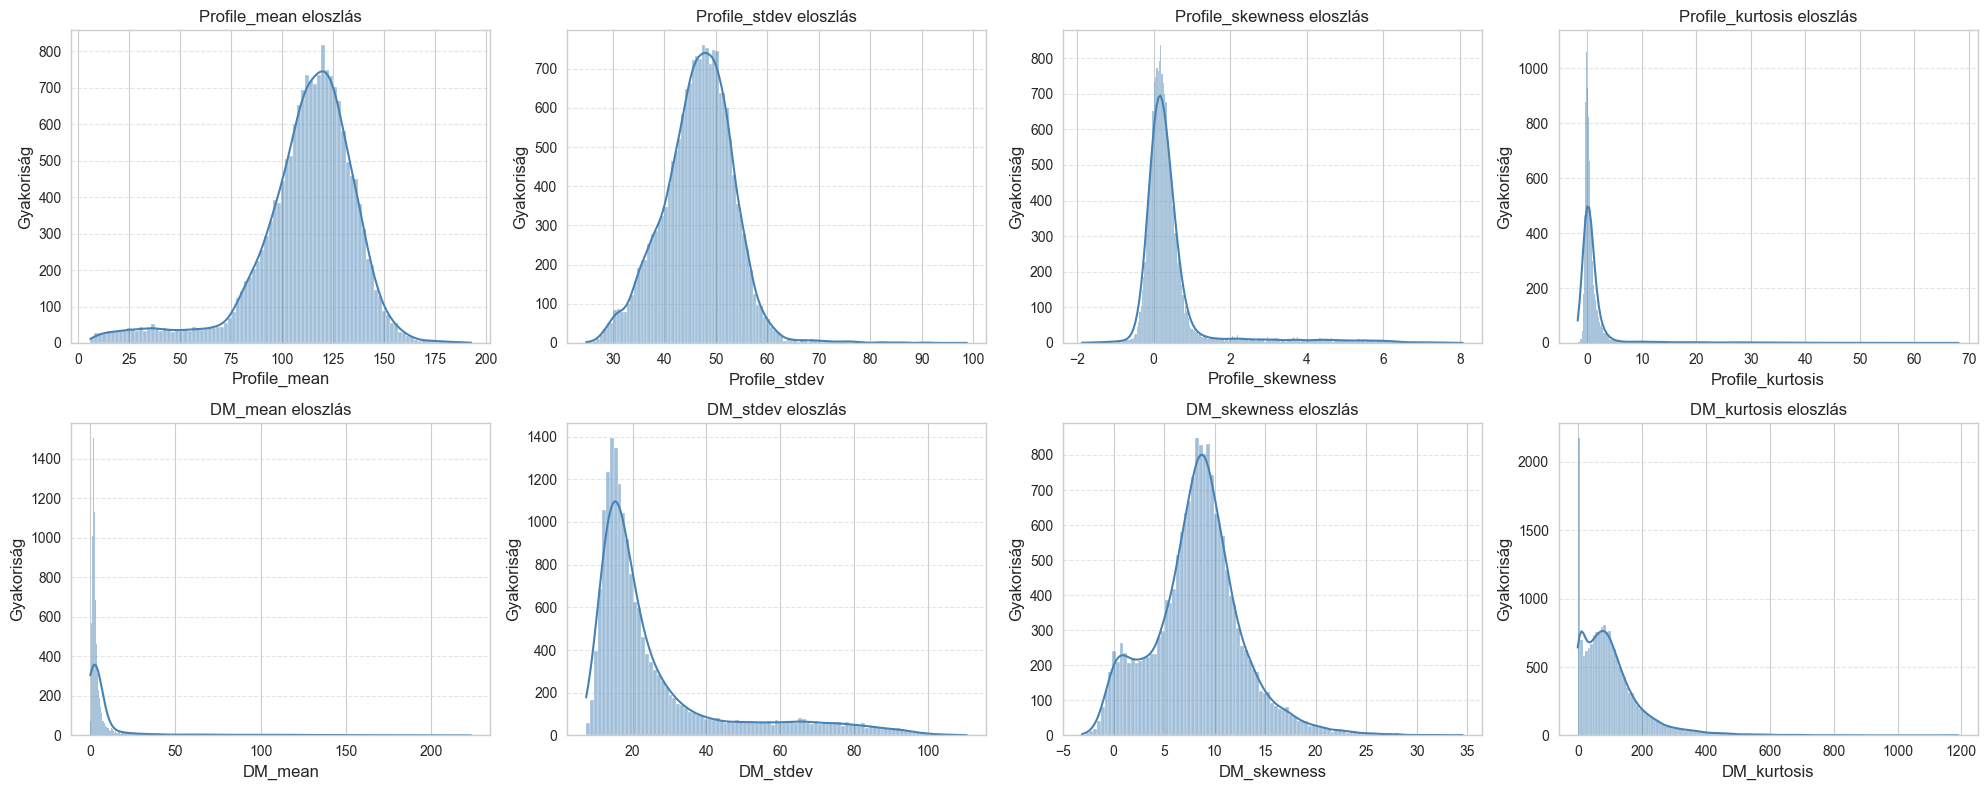

In [15]:
grafikon_eloszlas(X, feature_cimkek)

Itt a Profile_kurtosis kevésbé, de a DM_mean már sokkal jobban el van tolódva az ideálistól. Az igazi problémát szerintem a DM_kurtosis jelenti.

## Adat tisztítás

Az alábbi átalakítással csak egyetlen y=1 értéket dobok el, de ezekre a rekordok nagyon szélsőséges értékeket tartalmaznak.

In [16]:
megtartott_indexek = X[X["DM_kurtosis"] <= 500].index
X = X.iloc[megtartott_indexek, :]
X.reset_index(drop=True, inplace=True)
y = y.iloc[megtartott_indexek, :]
y.reset_index(drop=True, inplace=True)

Ez az átalakítás szintén egy y=1 adat elvesztésével jár, de a későbbi vizsgálatok során úgy döntöttem ezeket eltávolítom. Sajnos az eredmények nem elettek tőle jobbak, mint később kiderült.

In [17]:
megtartott_indexek = X[X["Profile_stdev"] <= 80].index
X = X.iloc[megtartott_indexek, :]
X.reset_index(drop=True, inplace=True)
y = y.iloc[megtartott_indexek, :]
y.reset_index(drop=True, inplace=True)

Próbálkoztam más oszlopok adatának tisztításával is, de csak a jelenleginél rosszabb eredményeket kaptam, a későbbi műveletek során.

## Adat átalakítás

A DM_kurtosis adatai nagyon ferdék, ezért ezen egy log transzformációt végzek.

In [18]:
X.loc[:,'DM_kurtosis'] = X['DM_kurtosis'] - X['DM_kurtosis'].min() + 1
X.loc[:,'DM_kurtosis'] = np.log(X['DM_kurtosis'])

Próbáltam más oszlopokon is transzformációkat végezni, de csak kevésbé értelmezhető adatokaz sikerült vele elérnem.

In [19]:
X.describe()

Profile_mean  Profile_stdev  Profile_skewness  Profile_kurtosis  \
count  17680.000000   17680.000000      17680.000000      17680.000000   
mean     111.034432      46.493830          0.481061          1.789253   
std       25.720726       6.720266          1.069328          6.202318   
min        5.812500      24.772042         -1.876011         -1.593648   
25%      100.927734      42.356972          0.027467         -0.187711   
50%      115.070312      46.935159          0.223547          0.200108   
75%      127.058594      50.998032          0.473664          0.935083   
max      192.617188      79.084407          8.069522         68.101622   

            DM_mean      DM_stdev   DM_skewness   DM_kurtosis  
count  17680.000000  17680.000000  17680.000000  17680.000000  
mean      12.646591     26.495506      8.131535      4.058649  
std       29.366751     19.468396      4.182597      1.349507  
min        0.520067      9.267690     -3.139270      0.000000  
25%        1.951296     14.542453      5.730812      3.617085  
50%        2.824415     18.554055      8.393776      4.442659  
75%        5.521321     28.601637     10.601753      4.939395  
max      222.421405    110.642211     21.788808      6.219158

In [20]:
grafikon_eloszlas(X, feature_cimkek)

In [21]:
X_std = pd.DataFrame(StandardScaler().fit_transform(X), columns=feature_cimkek)

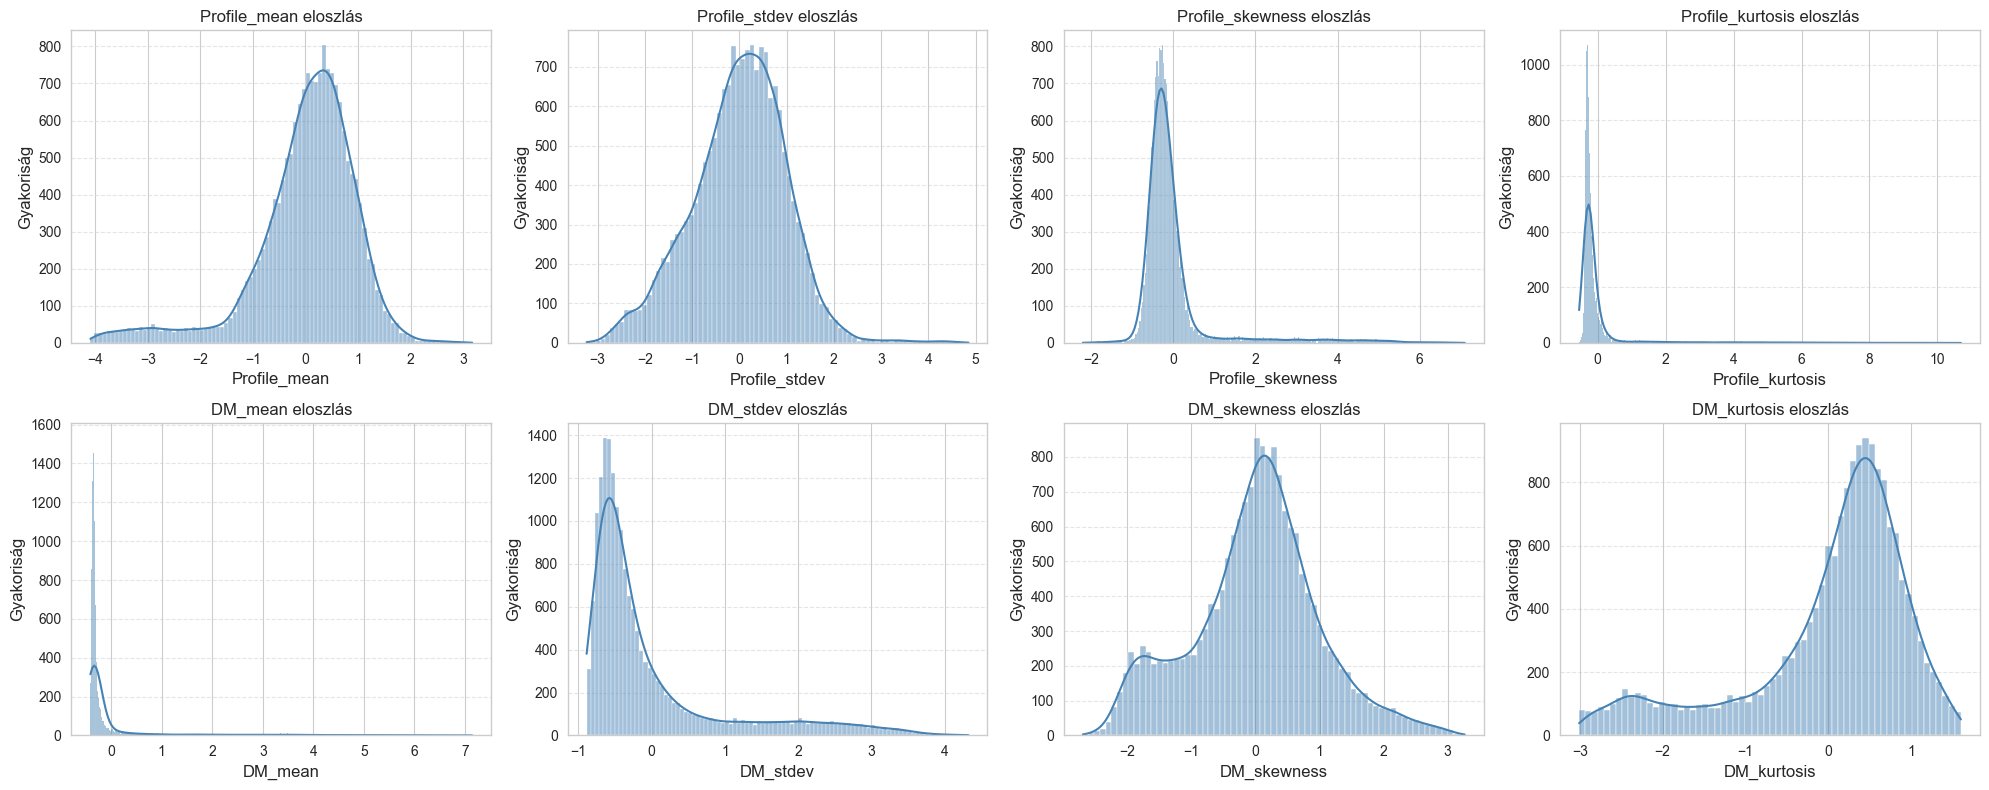

In [22]:
grafikon_eloszlas(X_std, feature_cimkek)

# Factor Analyzer

## Két faktor

In [23]:
fa = FactorAnalyzer(n_factors=2, rotation=None)
fa_scores = fa.fit_transform(X_std)

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
fa_df = pd.DataFrame(fa.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa.n_factors)], index=feature_cimkek)
fa_df = pd.concat([fa_df, 
                   pd.DataFrame(fa.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df

faktor 1  faktor 2  Kommunalitás  Specifitás
Profile_mean     -0.660174 -0.556965      0.746040    0.253960
Profile_stdev    -0.339487 -0.531126      0.397346    0.602654
Profile_skewness  0.823601  0.567111      0.999933    0.000067
Profile_kurtosis  0.769357  0.503593      0.845515    0.154485
DM_mean           0.716422 -0.319872      0.615579    0.384421
DM_stdev          0.853091 -0.461675      0.940908    0.059092
DM_skewness      -0.758488  0.456828      0.783997    0.216003
DM_kurtosis      -0.875981  0.494311      1.011686   -0.011686

A Kommunalitás nem tudom, hogyan lehet 1 feletti, gondolom ez vagy számítási hiba, vagy esetleg nem megfelelő skálázás/outlierek. Azonban itt bármelyik skálázást is használtam, hasonlóan furcsa eredmény jött ki.
Érdekes még a Profile_stdev is, amit a két faktor csak nagyon alacsony mértékben magyaráz.

In [25]:
fa_6 = FactorAnalyzer(n_factors=6, rotation=None)
fa_scores_6 = fa_6.fit_transform(X_std)
fa_df_6 = pd.DataFrame(fa_6.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa_6.n_factors)], index=feature_cimkek)
fa_df_6 = pd.concat([fa_df_6, 
                   pd.DataFrame(fa_6.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa_6.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df_6

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


faktor 1  faktor 2  faktor 3  faktor 4  faktor 5  faktor 6  \
Profile_mean     -0.688226 -0.597414  0.132618  0.333904 -0.056574  0.020998   
Profile_stdev    -0.350915 -0.558331  0.220174 -0.092753  0.257605  0.046693   
Profile_skewness  0.816788  0.542307  0.094162  0.014067  0.131395  0.082619   
Profile_kurtosis  0.788777  0.517896  0.172962  0.270824  0.021961 -0.022407   
DM_mean           0.729355 -0.340119  0.271179 -0.114521 -0.044601 -0.133743   
DM_stdev          0.851957 -0.468286  0.065110 -0.066656 -0.171298  0.109131   
DM_skewness      -0.782305  0.497568  0.284937 -0.122763 -0.152958  0.052095   
DM_kurtosis      -0.864472  0.488460  0.086936 -0.018994  0.016627 -0.030485   

                  Kommunalitás  Specifitás  
Profile_mean          0.963279    0.036721  
Profile_stdev         0.560495    0.439505  
Profile_skewness      0.994396    0.005604  
Profile_kurtosis      0.994631    0.005369  
DM_mean               0.754169    0.245831  
DM_stdev              0.995058    0.004942  
DM_skewness           0.981945    0.018055  
DM_kurtosis           0.995029    0.004971

Ha 6 faktorra próbálom csökkenteni, a Profile_stdev (legalábbis annak szórása) akkor is csak kis mértékben magyarázható a faktorokkal.

### Varimax forgatás

In [26]:
fa_vm = FactorAnalyzer(n_factors=2, rotation='varimax')
fa_scores_vm = fa_vm.fit_transform(X_std)

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [27]:
fa_df = pd.DataFrame(fa_vm.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa_vm.n_factors)], index=feature_cimkek)
fa_df = pd.concat([fa_df, 
                   pd.DataFrame(fa_vm.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa_vm.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df

faktor 1  faktor 2  Kommunalitás  Specifitás
Profile_mean     -0.181344 -0.844485      0.746040    0.253960
Profile_stdev     0.056487 -0.627818      0.397346    0.602654
Profile_skewness  0.304395  0.952511      0.999933    0.000067
Profile_kurtosis  0.300359  0.869080      0.845515    0.154485
DM_mean           0.762372  0.185384      0.615579    0.384421
DM_stdev          0.957238  0.156856      0.940908    0.059092
DM_skewness      -0.879448 -0.102802      0.783997    0.216003
DM_kurtosis      -0.995313 -0.145049      1.011686   -0.011686

Ezek pontosan ugyan azok a problémák, mint forgatás nélkül, tehát a forgatás ezen nem segített ezek értelmezésében.

### Árázolás

In [28]:
X_fa = pd.DataFrame(data = fa_scores, columns = ['Faktor 1', 'Faktor 2'])
X_fa_vm = pd.DataFrame(data = fa_scores_vm, columns = ['Faktor 1 (varimax)', 'Faktor 2 (varimax)'])
X_2dim_fa = pd.concat([X_fa, X_fa_vm, y], axis = 1)
X_2dim_fa.head()

Faktor 1  Faktor 2  Faktor 1 (varimax)  Faktor 2 (varimax)  class
0 -0.587026 -0.517122           -0.147868           -0.768212      0
1 -0.462809  0.296133           -0.547255           -0.048974      0
2 -0.194370  0.041412           -0.179074           -0.086181      0
3 -0.250197 -0.655073            0.202952           -0.671215      0
4 -0.558942  0.969556           -1.035360            0.424834      0

In [29]:
fa_data = { "data" : X_2dim_fa, "x_label" : "Faktor 1", "y_label" : "Faktor 2",
        "figs" : [
            {"id": 0, "method": "Faktor Analyzer", "msg": "eredeti", "x": "Faktor 1", "y": "Faktor 2"},
            {"id": 1, "method": "Faktor Analyzer", "msg": "varimax", "x": "Faktor 1 (varimax)", "y": "Faktor 2 (varimax)"}
        ]}

In [30]:
grafikon_scatter_2d(fa_data)

A hibák ellenére azért itt kirajzolódik két egészen jól elkülönülő klaszter. A pirosak közepén ugyan láthatóak a yöld klaszter tagjai is, lehet, hogy ezen egy harmadik faktor segítene.

## Három faktor

In [31]:
fa_3 = FactorAnalyzer(n_factors=3, rotation=None)
fa_scores_3 = fa_3.fit_transform(X_std)
fa_df_3 = pd.DataFrame(fa_3.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa_3.n_factors)], index=feature_cimkek)
fa_df_3 = pd.concat([fa_df_3, 
                   pd.DataFrame(fa_3.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa_3.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df_3

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


faktor 1  faktor 2  faktor 3  Kommunalitás  Specifitás
Profile_mean     -0.654608 -0.561921  0.024443      0.744865    0.255135
Profile_stdev    -0.337305 -0.541694  0.144400      0.428058    0.571942
Profile_skewness  0.817530  0.574026  0.051169      1.000480   -0.000480
Profile_kurtosis  0.764116  0.510421  0.043238      0.846271    0.153729
DM_mean           0.747118 -0.341378  0.359793      0.804175    0.195825
DM_stdev          0.847950 -0.442704  0.029305      0.915865    0.084135
DM_skewness      -0.773141  0.464268  0.240482      0.871124    0.128876
DM_kurtosis      -0.875555  0.480236  0.134650      1.015353   -0.015353

Itt nagyjából ugyanazok a problémáim megmaradtak: a DM_skewness 1 feletti értéke és a Profile_stdev alacsony kommunalitás értéke.

### Oblimin forgatás

In [32]:
fa_3_om = FactorAnalyzer(n_factors=3, rotation='oblimin')
fa_scores_3_om = fa_3_om.fit_transform(X_std)
fa_df_3_om = pd.DataFrame(fa_3_om.loadings_, 
                     columns=[f'faktor {i+1}' for i in range(fa_3_om.n_factors)], index=feature_cimkek)
fa_df_3_om = pd.concat([fa_df_3_om, 
                   pd.DataFrame(fa_3_om.get_communalities(), columns=['Kommunalitás'], index=feature_cimkek),
                   pd.DataFrame(1 - fa_3_om.get_communalities(), columns=['Specifitás'], index=feature_cimkek)], axis=1)
fa_df_3_om

/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tothi/pysrc/pemik/nfgt/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


faktor 1  faktor 2  faktor 3  Kommunalitás  Specifitás
Profile_mean     -0.875540  0.004210  0.053033      0.769401    0.230599
Profile_stdev    -0.680716 -0.011816  0.267282      0.534954    0.465046
Profile_skewness  0.977671  0.005272  0.076144      0.961667    0.038333
Profile_kurtosis  0.889380 -0.018047  0.070583      0.796304    0.203696
DM_mean           0.100065 -0.208079  0.698954      0.541846    0.458154
DM_stdev          0.048717 -0.720878  0.276993      0.598764    0.401236
DM_skewness       0.021433  1.013550  0.106570      1.039099   -0.039099
DM_kurtosis      -0.022940  0.954610 -0.061186      0.915551    0.084449

A három faktor és a forgatás egy kicsit segített a Kommunalitáson, de most a DM_kurtosis kommunalitása van 1 felett.

### Ábrázolás

In [33]:
X_fa_3 = pd.DataFrame(data = fa_scores_3, columns = ['Faktor 1', 'Faktor 2', 'Faktor 3'])
X_fa_3_om = pd.DataFrame(data = fa_scores_3_om, columns = ['Faktor 1 (oblimin)', 'Faktor 2 (oblimin)', 'Faktor 3 (oblimin)'])
X_3dim_fa = pd.concat([X_fa_3, X_fa_3_om, y], axis = 1)
fa_3_data = { "data" : X_3dim_fa, "x_label" : "Faktor 1", "y_label" : "Faktor 2", "z_label" : "Faktor 3",
        "figs" : [
            {"id": 0, "method": "Faktor Analyzer", "msg": "eredeti", "x": "Faktor 1", "y": "Faktor 2", "z": "Faktor 3"},
            {"id": 1, "method": "Faktor Analyzer", "msg": "oblimin", "x": "Faktor 1 (oblimin)", "y": "Faktor 2 (oblimin)", "z": "Faktor 3 (oblimin)"}
        ]}

In [34]:
grafikon_scatter_3d(fa_3_data)

A forgatás itt nem sokat segít az ábra értelmezésében, a piros klaszter formája sokkal jobban megfigyelhető a forgatás nélkül.

# PCA

## Standardizálás

Mivel a standard scalerrel skálázott adatokon végzett faktor analízis során számomra nem minden esetben érthető eredmény született, ezért más féle módszereket is kipróbáltam a skálázásra. Ezek különböző módon kezelik az outlireket, ezért várhatóan más eredményt hoznak a PCA során.

In [35]:
X_rbst = pd.DataFrame(RobustScaler(unit_variance = True).fit_transform(X), columns=feature_cimkek)

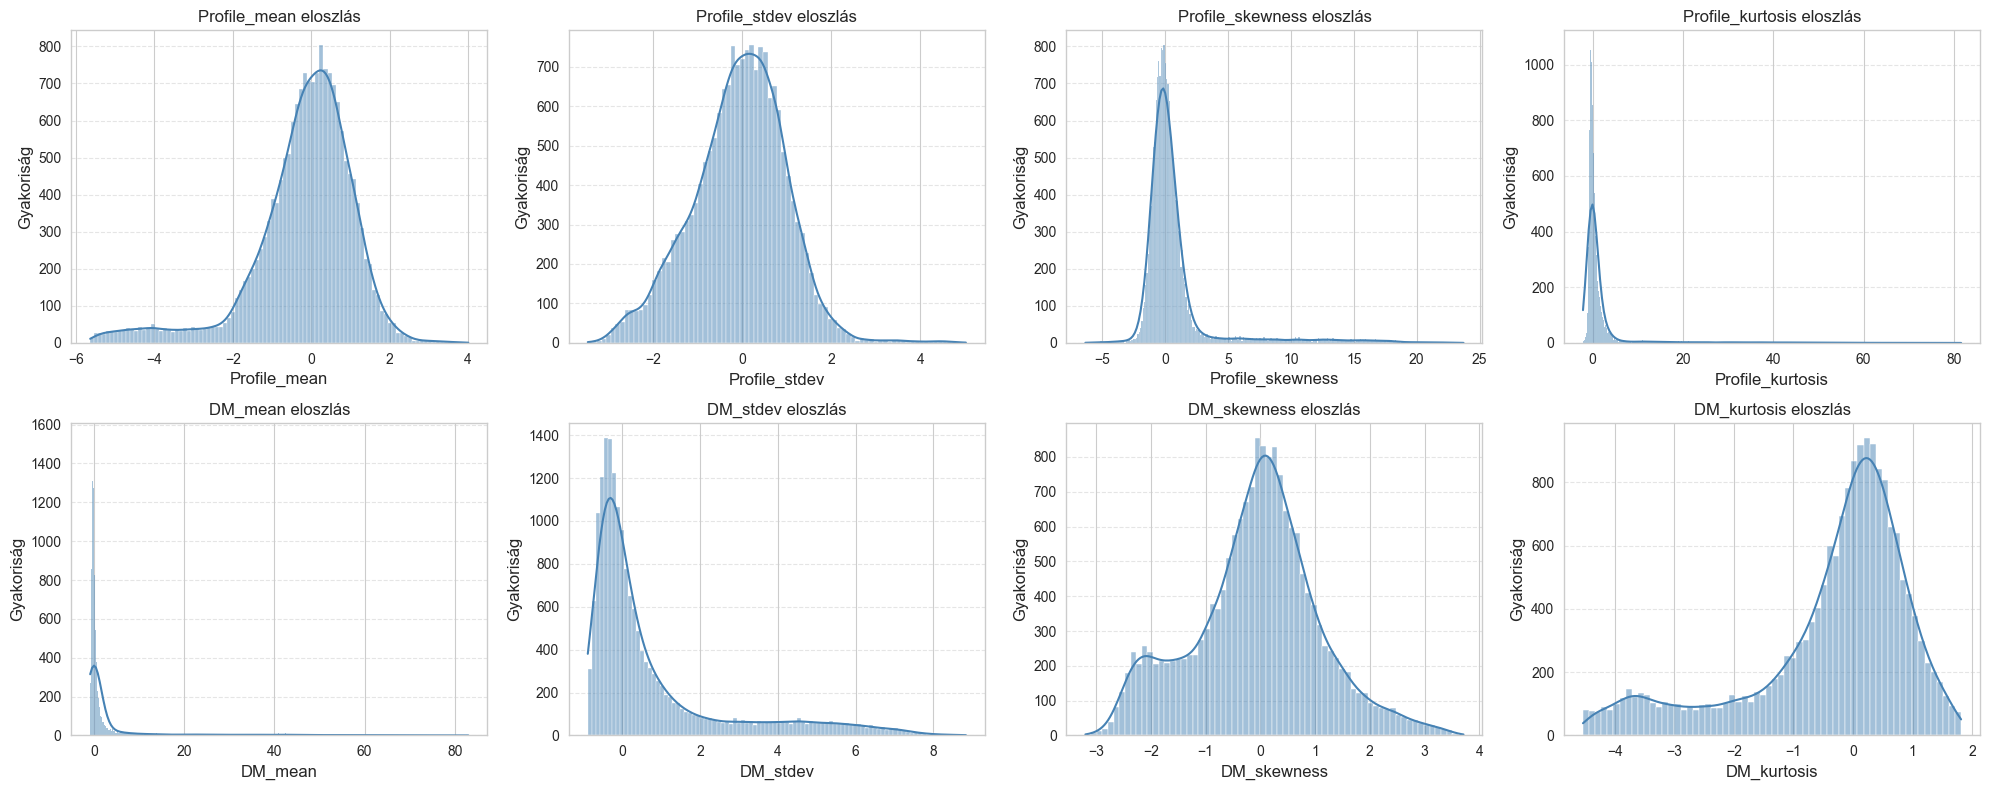

In [36]:
grafikon_eloszlas(X_rbst, feature_cimkek)

In [37]:
X_pwr = pd.DataFrame(PowerTransformer(method='yeo-johnson').fit_transform(X), columns=feature_cimkek)

In [38]:
grafikon_eloszlas(X_pwr, feature_cimkek)

## Két faktor

Első körben azt vizsgáltam meg, hogy a PCA segítségével hány főkomponensre lenne szükség, ha a varianciát legalább 95%-ban szeretném ha magyaráznák.

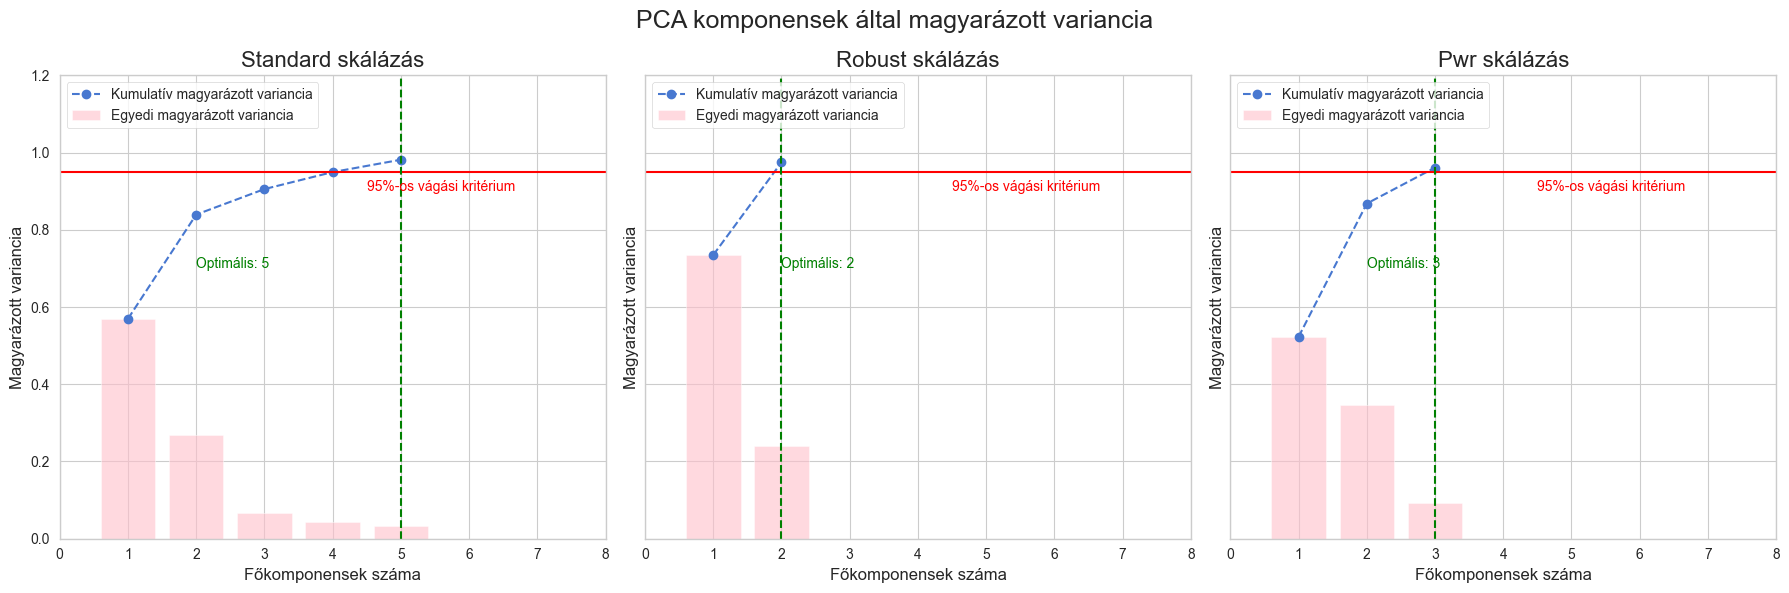

In [39]:
pca_results = {}
methods = {"standard": X_std, "robust": X_rbst, "pwr": X_pwr}

for tipus, adat in methods.items():
    pca = PCA(n_components = 0.95, svd_solver = 'full')
    pca.fit(adat)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = explained_variance_ratio.cumsum()
    optimal_num_components = len(cumulative_explained_variance[cumulative_explained_variance < 0.95]) + 1

    pca_results[tipus] = {
        "explained": explained_variance_ratio,
        "cumulative": cumulative_explained_variance,
        "optimal": optimal_num_components
    }

fig, axes = plt.subplots(1, len(methods), figsize=(len(methods) * 6, 6), sharey=True)
plt.suptitle("PCA komponensek által magyarázott variancia", fontsize=18)

for ax, (tipus, results) in zip(axes, pca_results.items()):
    ax.bar(range(1, len(results["explained"]) + 1), results["explained"], alpha=0.6, color='pink', label='Egyedi magyarázott variancia')
    ax.plot(range(1, len(results["cumulative"]) + 1), results["cumulative"], marker='o', linestyle='--', label='Kumulatív magyarázott variancia')
    ax.set_title(f'{tipus.capitalize()} skálázás', fontsize=16)
    ax.set_xlabel('Főkomponensek száma')
    ax.set_ylabel('Magyarázott variancia')
    ax.axis([0, 8, 0, 1.2])
    ax.axhline(y=0.95, color='r', linestyle='-')
    ax.axvline(x=results["optimal"], color='g', linestyle='--')
    ax.text(4.5, 0.9, '95%-os vágási kritérium', color='red', fontsize=10)
    ax.text(2, 0.7, f'Optimális: {results["optimal"]}', color='green', fontsize=10)
    ax.grid(True)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


A fentiek alapján a Robust skálázást és a két főkomponenst választottam.

### Töltősúlyok

In [74]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_rbst)
pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

rotator_vm = Rotator(method='varimax')
varimax_loadings = rotator_vm.fit_transform(pca_loadings)

rotator_ob = Rotator(method='oblimin')
oblimin_loadings = rotator_ob.fit_transform(pca_loadings)

pca_df = pd.DataFrame(pca_loadings, columns=[f'PCA PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
varimax_df = pd.DataFrame(varimax_loadings, columns=[f'Varimax PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
oblimin_df = pd.DataFrame(oblimin_loadings, columns=[f'Oblimin PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
combined_df = pd.concat([pca_df, varimax_df, oblimin_df], axis=1)

print("Főkomponensek töltősúlyai:")
print(combined_df)

Főkomponensek töltősúlyai:
                   PCA PC 1  PCA PC 2  Varimax PC 1  Varimax PC 2  \
Profile_mean      -0.642674 -0.806803     -0.302683     -0.986075   
Profile_stdev     -0.185391 -0.613969      0.052256     -0.639217   
Profile_skewness   2.065542  2.334812      1.067359      2.928917   
Profile_kurtosis   4.823958  5.660293      2.416802      7.033389   
DM_mean           10.677280 -3.010442     11.038135      1.107542   
DM_stdev           1.507110 -0.245040      1.492188      0.323729   
DM_skewness       -0.766612  0.114307     -0.755237     -0.174288   
DM_kurtosis       -1.076474  0.148393     -1.056067     -0.256010   

                  Oblimin PC 1  Oblimin PC 2  
Profile_mean          1.046871      0.038183  
Profile_stdev         0.705948      0.283404  
Profile_skewness     -3.090992      0.061789  
Profile_kurtosis     -7.438679     -0.003931  
DM_mean               0.000499     11.093768  
DM_stdev             -0.190540      1.437369  
DM_skewness           

In [80]:
cov_matrix = pca.get_covariance()
cov_df = pd.DataFrame(cov_matrix, index=feature_cimkek, columns=feature_cimkek)
cov_df

Profile_mean  Profile_stdev  Profile_skewness  \
Profile_mean          1.887261       0.605118         -3.170518   
Profile_stdev         0.605118       1.241610         -1.789071   
Profile_skewness     -3.170518      -1.789071         10.434729   
Profile_kurtosis     -7.569017      -4.303421         22.890637   
DM_mean              -4.436481      -0.152257         15.022517   
DM_stdev             -0.768800      -0.129997          2.533074   
DM_skewness           0.399253       0.072360         -1.312191   
DM_kurtosis           0.570234       0.108916         -1.870369   

                  Profile_kurtosis     DM_mean   DM_stdev  DM_skewness  \
Profile_mean             -7.569017   -4.436481  -0.768800     0.399253   
Profile_stdev            -4.303421   -0.152257  -0.129997     0.072360   
Profile_skewness         22.890637   15.022517   2.533074    -1.312191   
Profile_kurtosis         55.450634   34.470651   5.865908    -3.041251   
DM_mean                  34.470651  123.091419  16.724307    -8.476471   
DM_stdev                  5.865908   16.724307   3.154446    -1.176262   
DM_skewness              -3.041251   -8.476471  -1.176262     1.434258   
DM_kurtosis              -4.337898  -11.866805  -1.648788     0.837171   

                  DM_kurtosis  
Profile_mean         0.570234  
Profile_stdev        0.108916  
Profile_skewness    -1.870369  
Profile_kurtosis    -4.337898  
DM_mean            -11.866805  
DM_stdev            -1.648788  
DM_skewness          0.837171  
DM_kurtosis          2.010884

In [82]:
original_cov = np.cov(X_rbst.T)
original_cov_df = pd.DataFrame(original_cov, index=feature_cimkek, columns=feature_cimkek)
original_cov_df

Profile_mean  Profile_stdev  Profile_skewness  \
Profile_mean          1.763071       0.779678         -3.754479   
Profile_stdev         0.779678       1.100651         -1.805309   
Profile_skewness     -3.754479      -1.805309         10.451518   
Profile_kurtosis     -7.327861      -4.287125         22.795916   
DM_mean              -4.439795      -0.156569         15.006002   
DM_stdev             -0.764364      -0.109860          2.619096   
DM_skewness           0.380901       0.041198         -1.347773   
DM_kurtosis           0.560899       0.078462         -1.929228   

                  Profile_kurtosis     DM_mean   DM_stdev  DM_skewness  \
Profile_mean             -7.327861   -4.439795  -0.764364     0.380901   
Profile_stdev            -4.287125   -0.156569  -0.109860     0.041198   
Profile_skewness         22.795916   15.006002   2.619096    -1.347773   
Profile_kurtosis         55.528902   34.485935   5.796408    -3.002162   
DM_mean                  34.485935  123.134559  16.562370    -8.337654   
DM_stdev                  5.796408   16.562370   3.489400    -1.819413   
DM_skewness              -3.002162   -8.337654  -1.819413     1.341767   
DM_kurtosis              -4.289230  -11.724958  -2.480528     1.502710   

                  DM_kurtosis  
Profile_mean         0.560899  
Profile_stdev        0.078462  
Profile_skewness    -1.929228  
Profile_kurtosis    -4.289230  
DM_mean            -11.724958  
DM_stdev            -2.480528  
DM_skewness          1.502710  
DM_kurtosis          1.895372

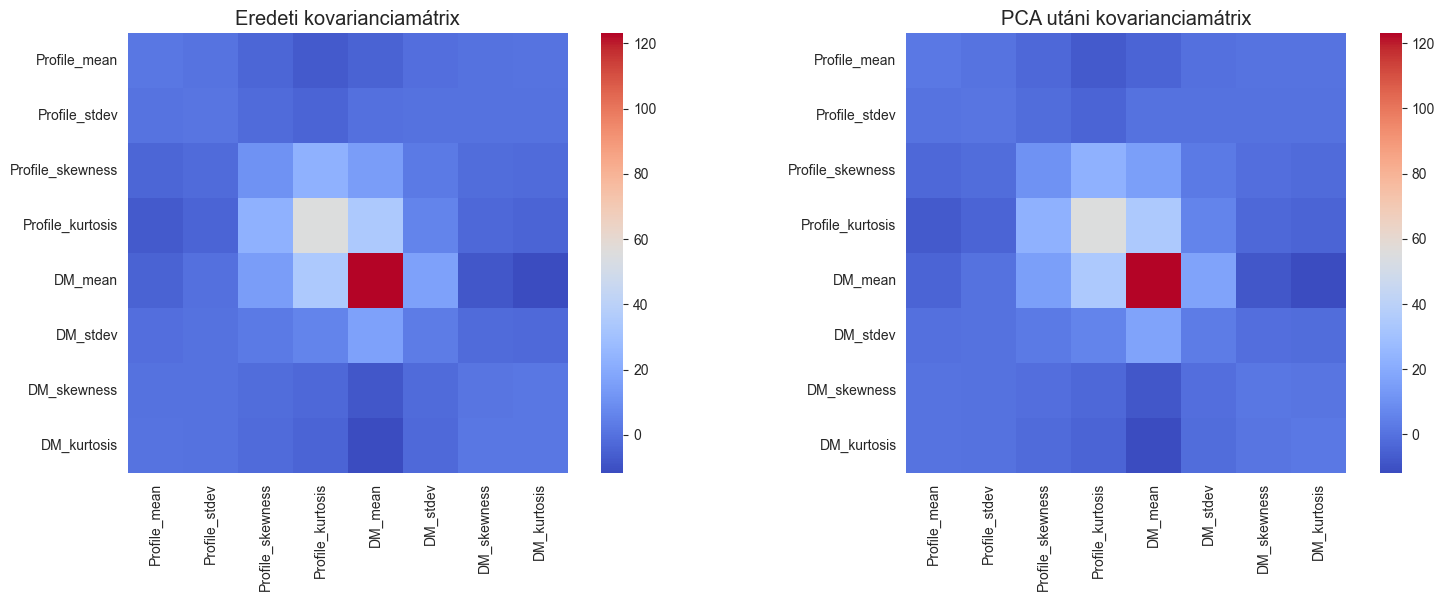

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(original_cov_df, annot=False, cmap="coolwarm", ax=axes[0], square=True)
axes[0].set_title("Eredeti kovarianciamátrix")

sns.heatmap(cov_df, annot=False, cmap="coolwarm", ax=axes[1], square=True)
axes[1].set_title("PCA utáni kovarianciamátrix")

plt.tight_layout()
plt.show()

In [86]:
explained_ratio = np.trace(cov_df) / np.trace(original_cov_df)
print(f"A PCA a teljes kovariancia {explained_ratio:.2%}-át magyarázza.")

A PCA a teljes kovariancia 100.00%-át magyarázza.


### Ábrázolás

In [75]:
varimax_projection = pd.DataFrame(np.dot(X_rbst, varimax_loadings), columns = ['Varimax PC 1', 'Varimax PC 2'])
oblimin_projection = pd.DataFrame(np.dot(X_rbst, oblimin_loadings), columns = ['Oblimin PC 1', 'Oblimin PC 2'])
principal_df = pd.DataFrame(data = principal_components, columns = ['PCA PC 1', 'PCA PC 2'])
X_2dim_pca = pd.concat([principal_df, varimax_projection, oblimin_projection, y], axis = 1)

In [76]:
pca_data = { "data" : X_2dim_pca, "x_label" : "Főkomponens 1", "y_label" : "Főkomponens 2",
        "figs" : [
            {"id": 0, "method": "PCA", "msg": "eredeti", "x": "PCA PC 1", "y": "PCA PC 2"},
            {"id": 1, "method": "PCA", "msg": "Varimax", "x": "Varimax PC 1", "y": "Varimax PC 2"},
            {"id": 2, "method": "PCA", "msg": "Oblimin", "x": "Oblimin PC 1", "y": "Oblimin PC 2"}
        ]}

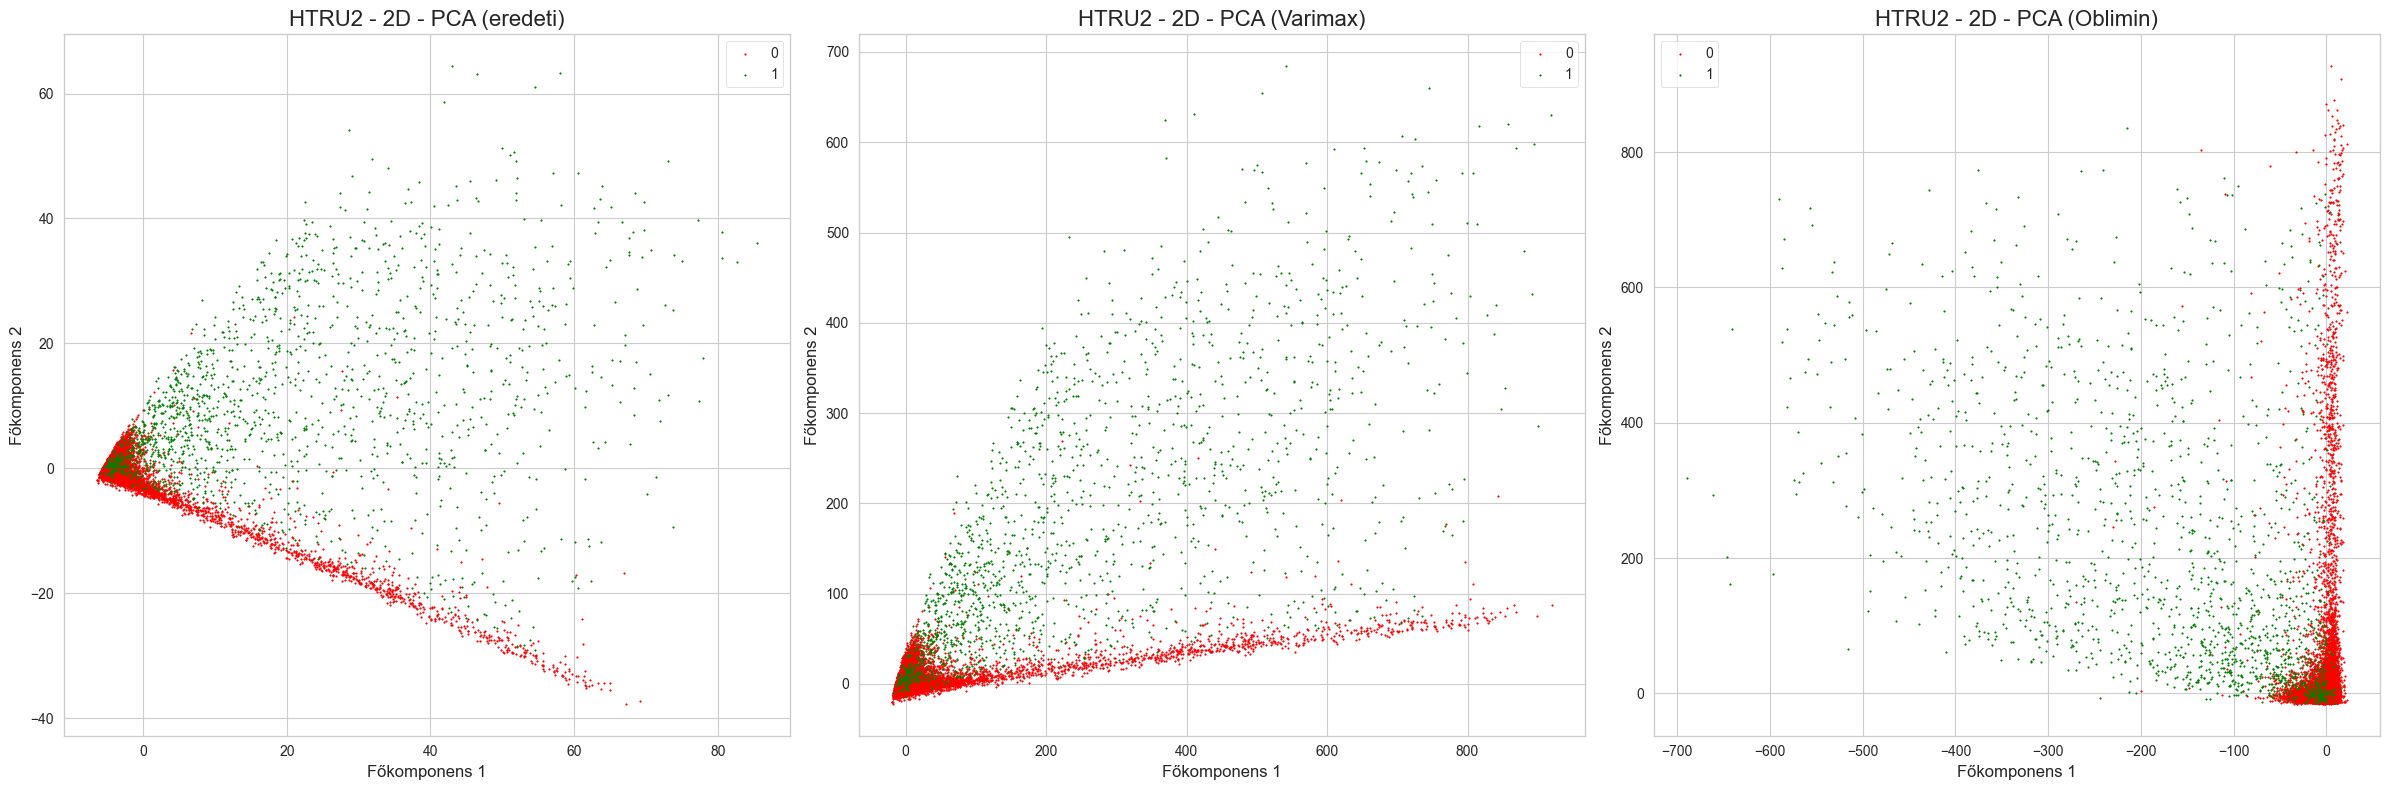

In [77]:
grafikon_scatter_2d(pca_data)

# MDS

Itt sajnos kenytelen vagyok az adatoknak csak egy reszen dolgozni, mert nagyon sokat fut az MDS a teljes adathalmazon.

In [44]:
sample_indexek = X_rbst.sample(1000, random_state=20190713).index
X_rbst_sample = X_rbst.loc[sample_indexek].reset_index(drop=True)
y_rbst_sample = y.loc[sample_indexek].reset_index(drop=True)

In [45]:
mds_nonmetr = MDS(n_components=2, n_init=5, verbose=1, metric=False, max_iter=100)
X_rbst_mds_nm = mds_nonmetr.fit_transform(X_rbst_sample)

breaking at iteration 1 with stress 0.30150089254800366
breaking at iteration 1 with stress 0.3011627526820571
breaking at iteration 1 with stress 0.3024570120648974
breaking at iteration 1 with stress 0.3014776297525179
breaking at iteration 1 with stress 0.30162758229555553


0.3-nal jobb stress erteket nem sikerult elernem a teljes adathalmazon sem.

In [46]:
mds_metr = MDS(n_components=2, n_init=5, verbose=1, metric=True, max_iter=1000)
X_rbst_mds_m = mds_metr.fit_transform(X_rbst_sample)

breaking at iteration 400 with stress 334349.76226866484
breaking at iteration 292 with stress 355782.71263751737
breaking at iteration 323 with stress 807579.3582240987
breaking at iteration 435 with stress 225344.92507180996
breaking at iteration 504 with stress 163166.68936450378


Ezek a stress ertekek nagyon rosszak, alkalmatlanok tovabbi vizsgalatra.

In [47]:
X_mds_nm = pd.DataFrame(data = X_rbst_mds_nm, columns = ['nonmetric PC 1', 'nonmetric PC 2'])
X_mds_m = pd.DataFrame(data = X_rbst_mds_m, columns = ['metric PC 1', 'metric PC 2'])
X_2dim_mds = pd.concat([X_mds_nm, X_mds_m, y_rbst_sample], axis = 1)
X_2dim_mds.head()

nonmetric PC 1  nonmetric PC 2  metric PC 1  metric PC 2  class
0        0.429045       -0.081433     1.361817    -5.439693      0
1        0.084311        0.391348     4.449676    -3.166475      0
2       -0.196111       -0.390759     1.910595    -6.087580      0
3        0.137287        0.444178     1.314733    -3.480701      0
4        0.182455       -0.017195     3.575580    -2.131599      0

In [48]:
mds_data = { "data" : X_2dim_mds, "x_label" : "Főkomponens 1", "y_label" : "Főkomponens 2",
        "figs" : [
            {"id": 0, "method": "MDS", "msg": "nem metrikus", "x": "nonmetric PC 1", "y": "nonmetric PC 2"},
            {"id": 1, "method": "MDS", "msg": "metrikus", "x": "metric PC 1", "y": "metric PC 2"}
        ]}

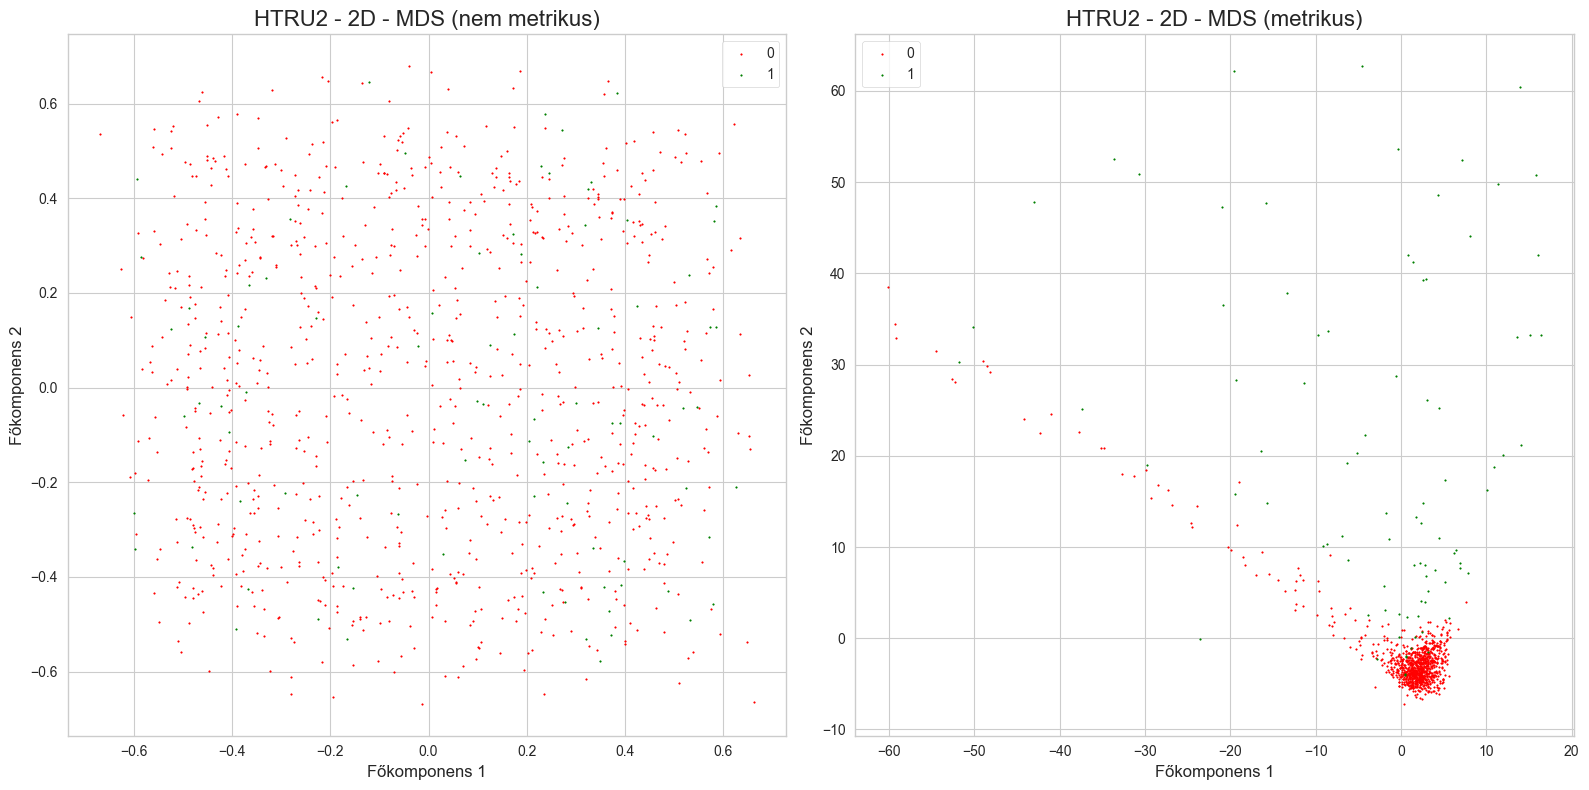

In [49]:
grafikon_scatter_2d(mds_data)

# ISOMAP

In [50]:
sample_indexek = X_rbst.sample(5000, random_state=20190713).index
X_rbst_sample = X_rbst.loc[sample_indexek].reset_index(drop=True)
y_rbst_sample = y.loc[sample_indexek].reset_index(drop=True)

## 5 szomszed

In [51]:
iso_eucl = Isomap(n_components=2, n_neighbors=5, metric='euclidean')
X_iso_rbst_eucl = iso_eucl.fit_transform(X_rbst_sample)

In [52]:
iso_manh = Isomap(n_components=2, n_neighbors=5, metric='manhattan')
X_iso_rbst_manh = iso_manh.fit_transform(X_rbst_sample)

In [53]:
iso_mbis = Isomap(n_components=2, n_neighbors=5, metric='mahalanobis', metric_params={'V': np.cov(X_rbst_sample.T)})
X_iso_rbst_mbis = iso_mbis.fit_transform(X_rbst_sample)

In [54]:
X_iso_euclidean = pd.DataFrame(data = X_iso_rbst_eucl, columns = ['euclidean PC 1', 'euclidean PC 2'])
X_iso_manhattan = pd.DataFrame(data = X_iso_rbst_manh, columns = ['manhattan PC 1', 'manhattan PC 2'])
X_iso_mahalanobis = pd.DataFrame(data = X_iso_rbst_mbis, columns = ['mahalanobis PC 1', 'mahalanobis PC 2'])
X_2dim_iso = pd.concat([X_iso_euclidean, X_iso_manhattan, X_iso_mahalanobis, y_rbst_sample], axis = 1)
X_2dim_iso.head()

euclidean PC 1  euclidean PC 2  manhattan PC 1  manhattan PC 2  \
0       -7.897686       -1.985895      -15.613626       -3.922941   
1       -8.247746        1.190076      -18.012365        0.959668   
2       -9.331908       -2.489795      -19.378268       -5.138624   
3       -5.706815       -1.090399      -10.489216       -1.077263   
4       -5.840692        1.661570      -10.541207        3.135413   

   mahalanobis PC 1  mahalanobis PC 2  class  
0         -1.856899         -0.940379      0  
1         -3.393382          0.548919      0  
2         -2.867413         -1.138221      0  
3         -0.664786         -0.685715      0  
4         -1.307707          1.179776      0

In [55]:
iso_data = { "data" : X_2dim_iso, "x_label" : "Főkomponens 1", "y_label" : "Főkomponens 2",
        "figs" : [
            {"id": 0, "method": "Isomap", "msg": "euclidean", "x": "euclidean PC 1", "y": "euclidean PC 2"},
            {"id": 1, "method": "Isomap", "msg": "manhattan", "x": "manhattan PC 1", "y": "manhattan PC 2"},
            {"id": 2, "method": "Isomap", "msg": "mahalanobis", "x": "mahalanobis PC 1", "y": "mahalanobis PC 2"}
        ]}

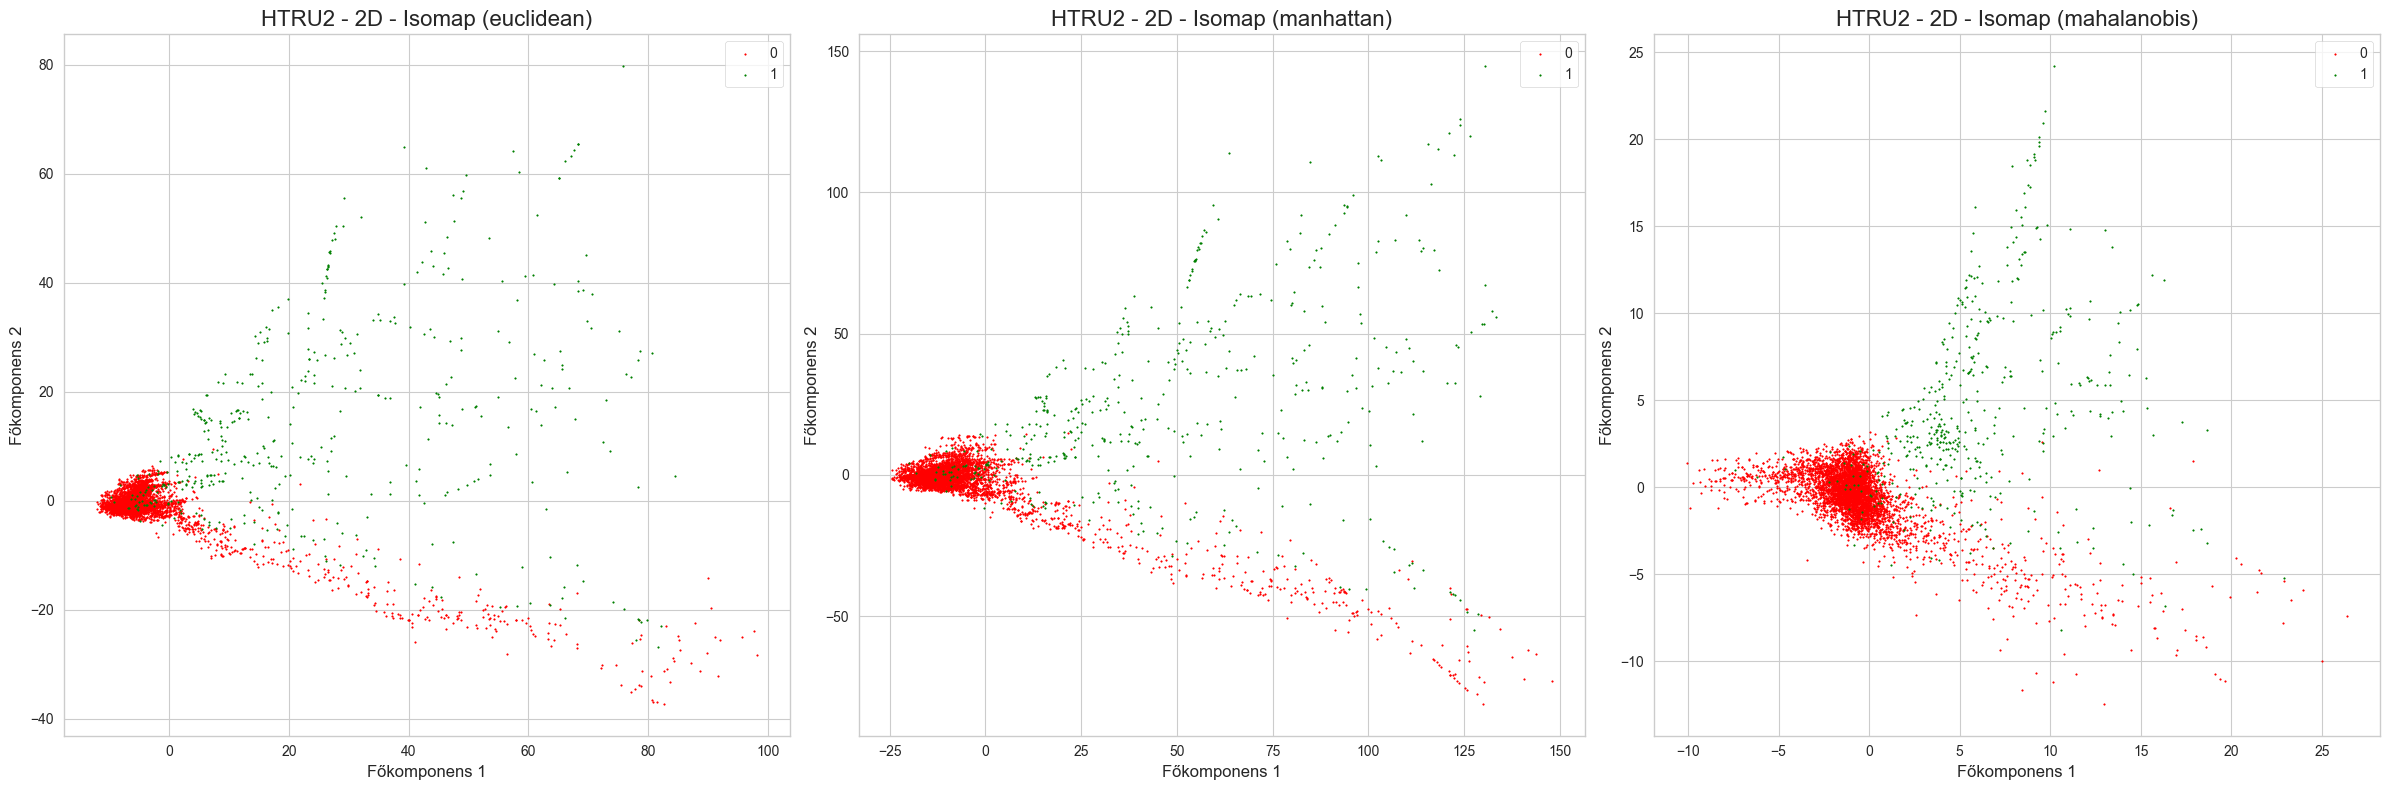

In [56]:
grafikon_scatter_2d(iso_data)

## 25 szomszed

In [57]:
sample_indexek = X_rbst.sample(2000, random_state=20190713).index
X_rbst_sample = X_rbst.loc[sample_indexek].reset_index(drop=True)
y_rbst_sample = y.loc[sample_indexek].reset_index(drop=True)

In [58]:
iso_eucl = Isomap(n_components=2, n_neighbors=25, metric='euclidean')
X_iso_rbst_eucl = iso_eucl.fit_transform(X_rbst_sample)

In [59]:
iso_manh = Isomap(n_components=2, n_neighbors=25, metric='manhattan')
X_iso_rbst_manh = iso_manh.fit_transform(X_rbst_sample)

In [60]:
iso_mbis = Isomap(n_components=2, n_neighbors=25, metric='mahalanobis', metric_params={'V': np.cov(X_rbst_sample.T)})
X_iso_rbst_mbis = iso_mbis.fit_transform(X_rbst_sample)

In [61]:
X_iso_euclidean = pd.DataFrame(data = X_iso_rbst_eucl, columns = ['euclidean PC 1', 'euclidean PC 2'])
X_iso_manhattan = pd.DataFrame(data = X_iso_rbst_manh, columns = ['manhattan PC 1', 'manhattan PC 2'])
X_iso_mahalanobis = pd.DataFrame(data = X_iso_rbst_mbis, columns = ['mahalanobis PC 1', 'mahalanobis PC 2'])
X_2dim_iso = pd.concat([X_iso_euclidean, X_iso_manhattan, X_iso_mahalanobis, y_rbst_sample], axis = 1)
X_2dim_iso.head()

euclidean PC 1  euclidean PC 2  manhattan PC 1  manhattan PC 2  \
0       -5.540560       -2.335334      -11.554278       -4.175392   
1       -6.020551        0.871218      -10.631524        3.704461   
2       -6.513686       -2.218365      -13.962006       -4.170196   
3       -3.756098       -1.098220       -7.152622       -1.212196   
4       -4.609673        1.791224       -7.657360        4.299521   

   mahalanobis PC 1  mahalanobis PC 2  class  
0         -1.152945         -1.098291      0  
1         -2.115752          0.335570      0  
2         -2.501945         -0.831077      0  
3         -0.572684         -0.174632      0  
4         -0.300415          1.027327      0

In [62]:
iso_data = { "data" : X_2dim_iso, "x_label" : "Főkomponens 1", "y_label" : "Főkomponens 2",
        "figs" : [
            {"id": 0, "method": "Isomap", "msg": "euclidean", "x": "euclidean PC 1", "y": "euclidean PC 2"},
            {"id": 1, "method": "Isomap", "msg": "manhattan", "x": "manhattan PC 1", "y": "manhattan PC 2"},
            {"id": 2, "method": "Isomap", "msg": "mahalanobis", "x": "mahalanobis PC 1", "y": "mahalanobis PC 2"}
        ]}

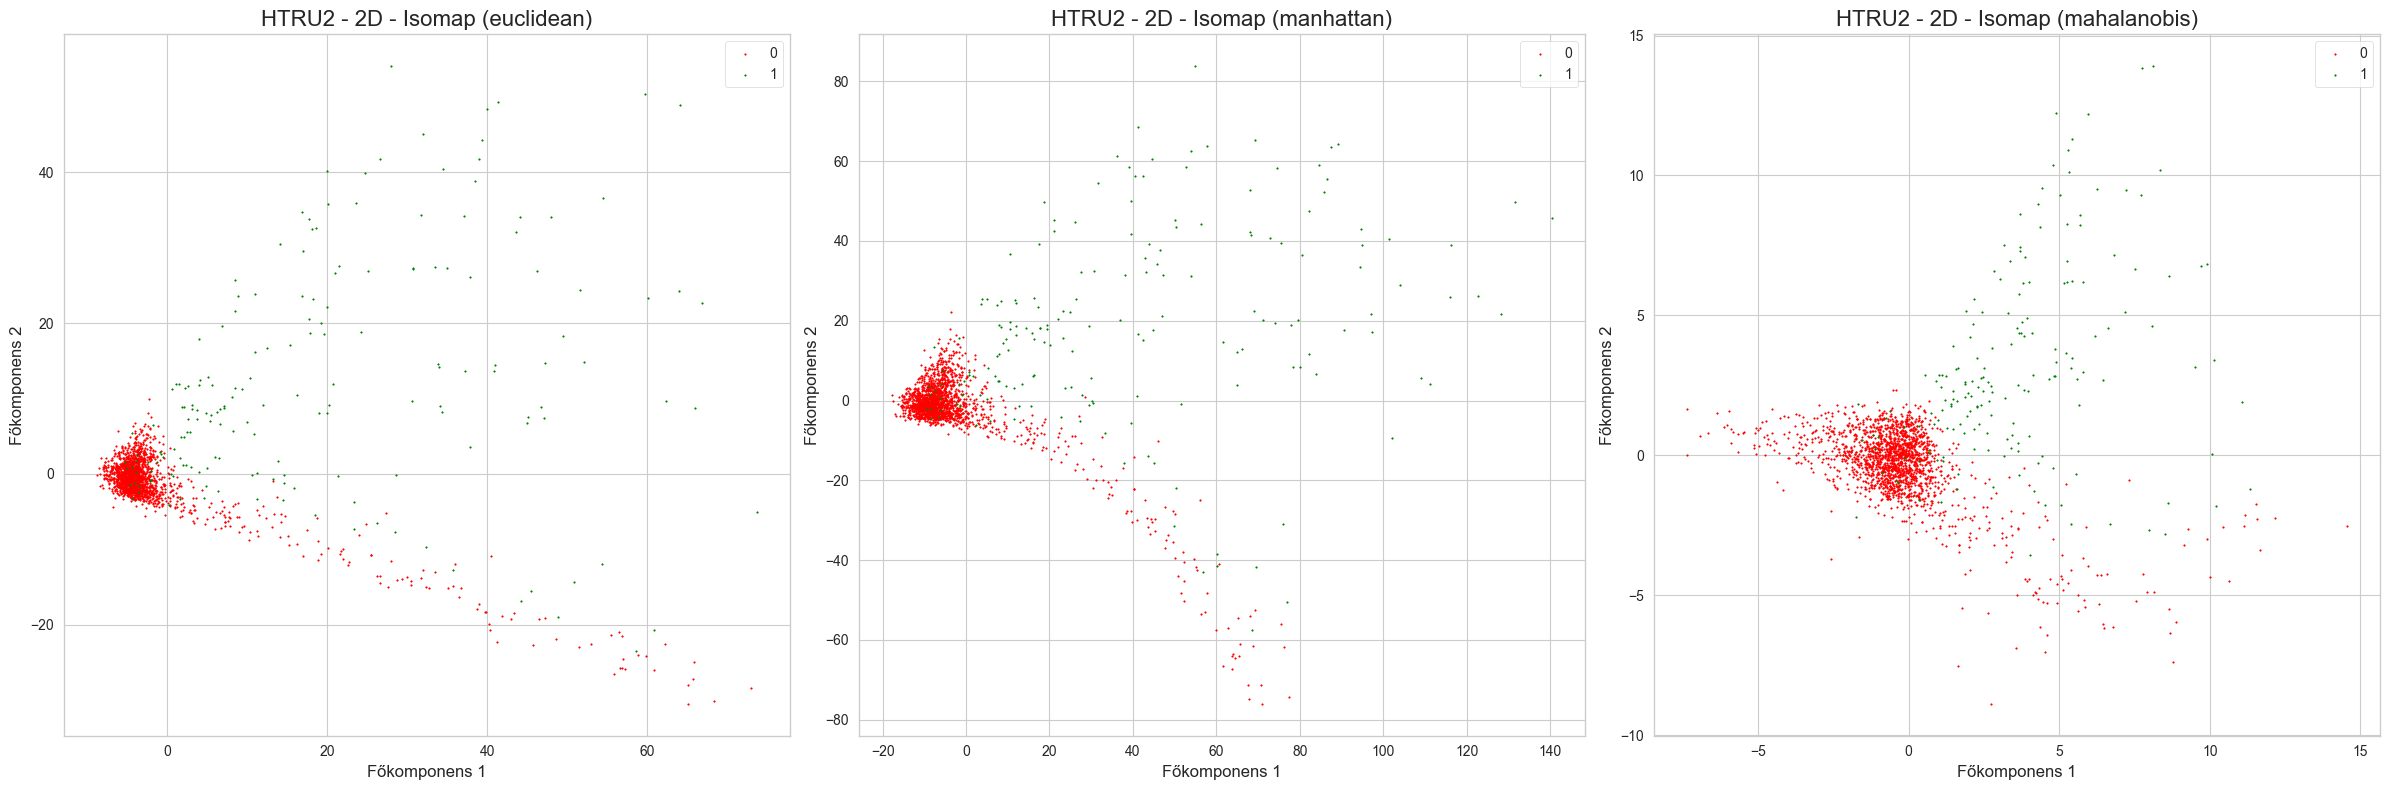

In [63]:
grafikon_scatter_2d(iso_data)

# PCA 3D

In [64]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_pwr)
pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

rotator_vm = Rotator(method='varimax')
varimax_loadings = rotator_vm.fit_transform(pca_loadings)

rotator_ob = Rotator(method='oblimin')
oblimin_loadings = rotator_ob.fit_transform(pca_loadings)

pca_df = pd.DataFrame(pca_loadings, columns=[f'PCA PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
varimax_df = pd.DataFrame(varimax_loadings, columns=[f'Varimax PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
oblimin_df = pd.DataFrame(oblimin_loadings, columns=[f'Oblimin PC {i+1}' for i in range(pca.n_components_)], index=feature_cimkek)
combined_df = pd.concat([pca_df, varimax_df, oblimin_df], axis=1)

In [65]:
varimax_projection = pd.DataFrame(np.dot(X_pwr, varimax_loadings), columns = ['Varimax PC 1', 'Varimax PC 2', 'Varimax PC 3'])
oblimin_projection = pd.DataFrame(np.dot(X_pwr, oblimin_loadings), columns = ['Oblimin PC 1', 'Oblimin PC 2', 'Oblimin PC 3'])
principal_df = pd.DataFrame(data = principal_components, columns = ['PCA PC 1', 'PCA PC 2',  'PCA PC 3'])
X_3dim_pca = pd.concat([principal_df, varimax_projection, oblimin_projection, y], axis = 1)
X_3dim_pca.head()

PCA PC 1  PCA PC 2  PCA PC 3  Varimax PC 1  Varimax PC 2  Varimax PC 3  \
0  1.270832 -2.738902  0.295578      0.480823     -3.877605     -3.503628   
1  1.631218 -0.610816  2.172671      2.721493     -2.846161     -0.406291   
2 -0.620891  1.009292 -0.575755     -0.485465      1.791225      1.108554   
3  0.677247 -2.617956  0.682568     -0.516003     -3.665810     -2.737636   
4  1.970290  2.627822  0.197900      5.482355      1.753703      1.485814   

   Oblimin PC 1  Oblimin PC 2  Oblimin PC 3  class  
0      0.105908     -3.211392     -2.661626      0  
1      2.731985     -3.166836      0.818392      0  
2     -0.375822      1.675734      0.601077      0  
3     -0.814882     -3.259502     -1.912826      0  
4      5.712442      1.520753      1.557442      0

In [66]:
pca_data_3d = { "data" : X_3dim_pca, "x_label" : "Főkomponens 1", "y_label" : "Főkomponens 2", "z_label" : "Főkomponens 3",
        "figs" : [
            {"id": 0, "method": "PCA", "msg": "eredeti", "x": "PCA PC 1", "y": "PCA PC 2", "z": "PCA PC 3"},
            {"id": 1, "method": "PCA", "msg": "Varimax", "x": "Varimax PC 1", "y": "Varimax PC 2", "z": "Varimax PC 3"},
            {"id": 2, "method": "PCA", "msg": "Oblimin", "x": "Oblimin PC 1", "y": "Oblimin PC 2", "z": "Oblimin PC 3"}
        ]}

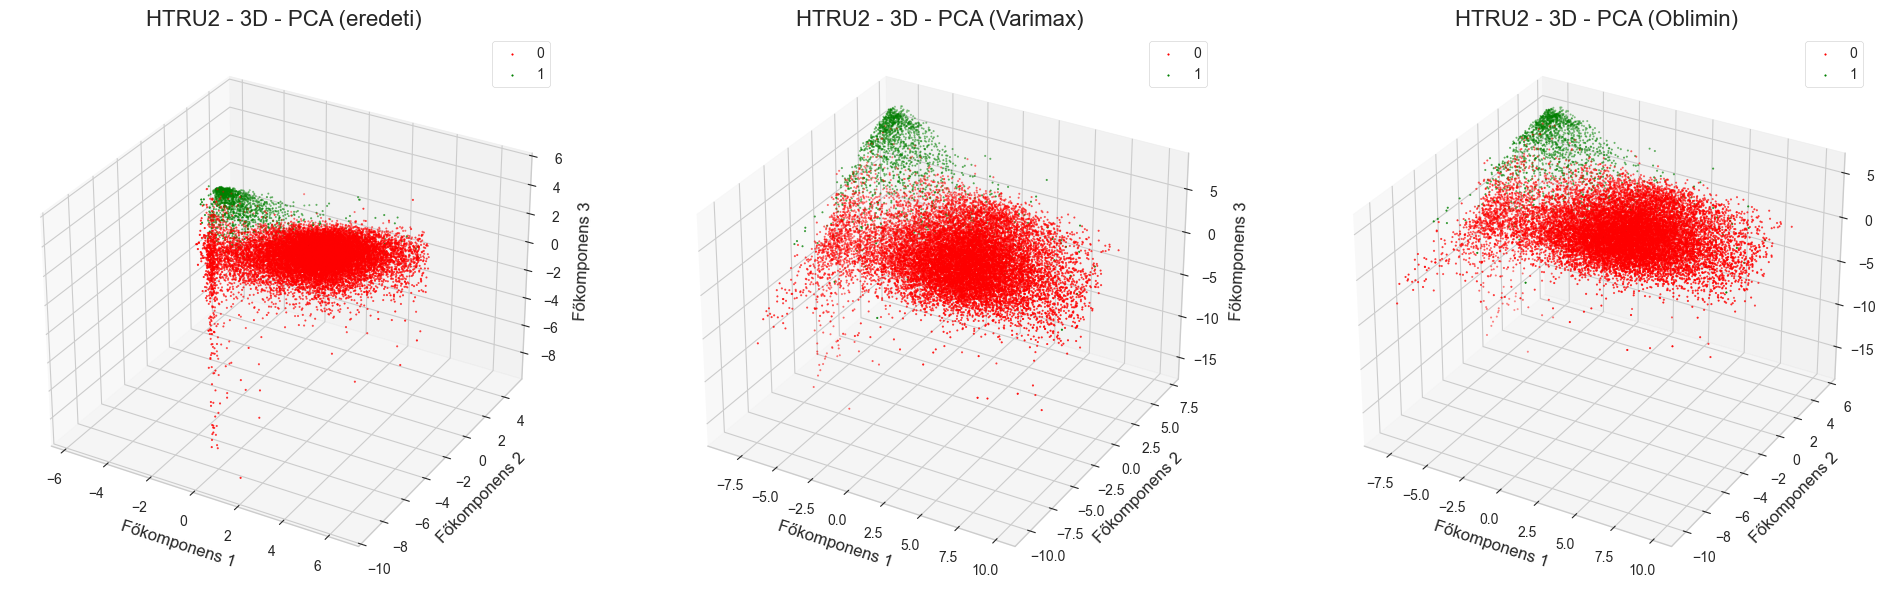

In [67]:
grafikon_scatter_3d(pca_data_3d)

In [68]:
grafikon_scatter_forgathato_3d(pca_data_3d)

In [69]:
iso_mbis = Isomap(n_components=3, n_neighbors=5, metric='mahalanobis', metric_params={'V': np.cov(X_pwr.T)})
X_iso_rbst_mbis = iso_mbis.fit_transform(X_pwr)

In [70]:
X_iso_mahalanobis = pd.DataFrame(data = X_iso_rbst_mbis, columns = ['mahalanobis PC 1', 'mahalanobis PC 2', 'mahalanobis PC 3'])
X_3dim_iso = pd.concat([X_iso_mahalanobis, y], axis = 1)
X_3dim_iso.head()

mahalanobis PC 1  mahalanobis PC 2  mahalanobis PC 3  class
0         -0.642569          1.751914          1.082733      0
1         -2.723586          0.767735          0.923838      0
2         -0.419852         -1.618005          0.365382      0
3         -0.077405          1.875254          1.223766      0
4         -3.972557         -0.244842         -2.099992      0

In [71]:
iso_data_3d = { "data" : X_3dim_iso, "x_label" : "Főkomponens 1", "y_label" : "Főkomponens 2", "z_label" : "Főkomponens 3",
        "figs" : [
            {"id": 0, "method": "Isomap", "msg": "mahalanobis", "x": "mahalanobis PC 1", "y": "mahalanobis PC 2", "z": "mahalanobis PC 3"}
        ]}

In [72]:
grafikon_scatter_forgathato_3d(iso_data_3d)